<h1> Quora Insincere Questions Classification </h1>

<h2> Overview </h2>
<pre>
An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle 
this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with 
others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those 
founded upon false premises, or that intend to make a statement rather than look for helpful answers.

In this competition, Kagglers will develop models that identify and flag insincere questions. To date, Quora has 
employed both machine learning and manual review to address this problem. With your help, they can develop more 
scalable methods to detect toxic and misleading content.

Here's your chance to combat online trolls at scale. Help Quora uphold their policy of “Be Nice, Be Respectful” and 
continue to be a place for sharing and growing the world’s knowledge.
</pre>

<h2>General Description</h2>
<pre>
In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. 
Some characteristics that can signify that a question is insincere:

<b>Has a non-neutral tone</b>

<li>Has an exaggerated tone to underscore a point about a group of people</li>
<li>Is rhetorical and meant to imply a statement about a group of people</li>
<b>Is disparaging or inflammatory</b>

<li>Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype</li>
<li>Makes disparaging attacks/insults against a specific person or group of people</li>
<li>Based on an outlandish premise about a group of people</li>
<li>Disparages against a characteristic that is not fixable and not measurable</li>
<b>Isn't grounded in reality</b>

<li>Based on false information, or contains absurd assumptions</li>
<b>Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers</b>

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The 
ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution 
of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization 
measures that have been applied to the final dataset.
</pre>

<h2>Data Fields</h2>
<pre><li>qid - unique question identifier</li></pre>
<pre><li>question_text - Quora question text</li></pre>
<pre><li>target - a question labeled "insincere" has a value of 1, otherwise 0</li></pre>

<h2>Evaluation</h2>

<pre>Submissions are evaluated on F1 Score between the predicted and the observed targets.</pre>

<h1>Import Data</h1>

In [1]:
import re
import os
import nltk
import time
import scipy
import string
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as pt
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
#importing given dataset
quora_train = pd.read_csv('train.csv')
quora_test = pd.read_csv('test.csv')

In [4]:
quora_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


<pre>From info we can see that there is no missing values present here.</pre>

In [5]:
print('---Insincere Questions in the train dataset---')
print(quora_train.loc[400,'question_text'])
print(quora_train.loc[822,'question_text'])

print('\n---Sincere Questions in the the train dataset---')
print(quora_train.loc[2,'question_text'])
print(quora_train.loc[27,'question_text'])

---Insincere Questions in the train dataset---
Why did the Pope say that "Muslims are a curse to this world"?
How do I sell Pakistan? I need lots of money so I decided to sell Pakistan any one wanna buy?

---Sincere Questions in the the train dataset---
Why does velocity affect time? Does velocity affect space geometry?
How can I top CBSE in 6 months?


<h1>Exploratory Data Analysis</h1>

<h2>1. Target Variable Analysis</h2>

In [6]:
#number of questions in the train dataset in both the class
targets = quora_train['target'].value_counts()
print('Sincere Questions : ',targets[0])
print('Insincere Questions : ',targets[1])

Sincere Questions :  1225312
Insincere Questions :  80810


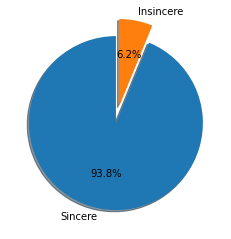

In [7]:
labels = 'Sincere', 'Insincere'
values = [targets[0], targets[1]]
explode = (0, 0.2)
pt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
pt.show()

<pre>
Only 6.2% of the questions belong to Insincere category. That means the dataset
is highly imbalanced and f1 score would be the major factor to decide how good 
is our model to predict the insincere questions.
</pre>

In [8]:
all_questions = pd.Series(quora_train['question_text'].tolist())
all_qids = pd.Series(quora_train['qid'].tolist())
print("Total unique qids and questions are {} and {} respectively."
      .format(len(np.unique(all_qids)),len(np.unique(all_questions))))

Total unique qids and questions are 1306122 and 1306122 respectively.


<pre>
The dataset doesn't any duplicate data. Both qid's and question_text has all values unique.
</pre>

<h2>2. Word analysis</h2>

In [9]:
insincere_train = quora_train[quora_train["target"]==1]
sincere_train = quora_train[quora_train["target"]==0]

def word_cloud(text):
    text_corpus = []
    for line in text.values:
        text_corpus.append(str(line).lower().split())
        
    num = 0
    comment_words = ' '
    while num < len(text_corpus):
        for word in text_corpus[num]:
            comment_words += word + ' '
            num += 1
    
    wordcloud = WordCloud(width = 1200, height = 800, stopwords = STOPWORDS, min_font_size = 20).generate(comment_words)
    pt.figure(figsize=(10,10))
    pt.imshow(wordcloud, interpolation='bilinear')
    pt.axis("off")
    pt.show()

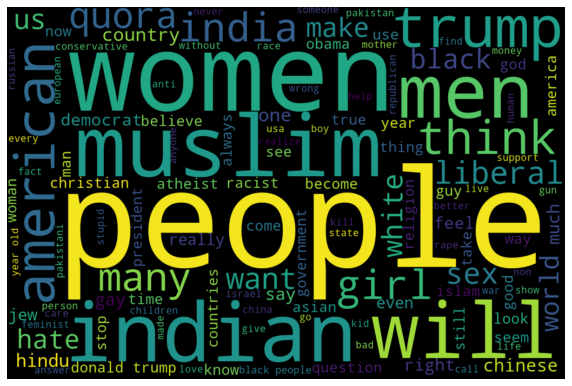

In [10]:
word_cloud(insincere_train['question_text'])

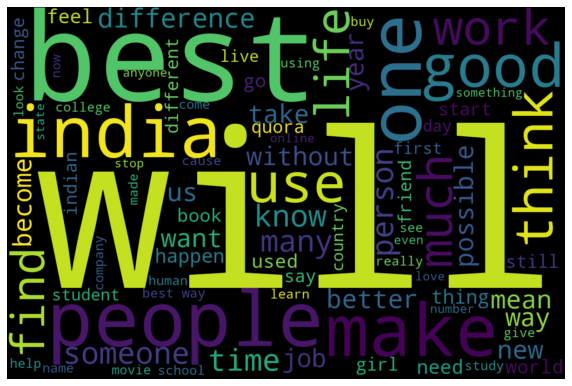

In [11]:
word_cloud(sincere_train['question_text'])

<pre>
<b>Observation:</b>
As we can see there is huge difference between both sincere and insincere word corpus. 
Sincere word corpus mostly have positive words, where as for insincere 
questions the words are based on religion, recism, slangs etc. 
From this we can say that ngram analysis would be a good approach.
</pre>

<h1>Data Preprocessing</h1>

<pre>This work is inspired from "Dieter's work" on how to preprocess text when embedding is provided. He has shown his work on "GoogleNews" embedding.
Link:- https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
</pre>


In [12]:
#Source: https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/176343
"""GloVe Embeddings"""
def GloVe(file_path):
    '''
    parameter : file_path(embedding file)
    return : embedding_matrix(dictionary)
    '''
    embeddings_glove = dict()
    with zipfile.ZipFile(file_path) as zf:
        with io.TextIOWrapper(zf.open("glove.840B.300d/glove.840B.300d.txt"), encoding="utf-8") as f:
            for line in tqdm(f):
                values=line.split(' ') # ".split(' ')" only for glove-840b-300d; for all other files, ".split()" works
                word=values[0]
                vectors=np.asarray(values[1:],'float32')
                embeddings_glove[word]=vectors
    return embeddings_glove

gloveModel = Embeddings("embeddings.zip",file="glove")

In [14]:
#checking coverage for words present in question_text and in embedding_matrix
def coverage(vocab, embedding,print_statement=False):
    #Initializing values
    known_words = defaultdict(int)
    unknown_words = defaultdict(int)
    knownWordsVal = 0
    unknownWordsVal = 0
    #iterating words
    for word in vocab.keys():
        try:
            known_words[word] = embedding[word]
            knownWordsVal += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            unknownWordsVal += vocab[word]
            pass
    
    if print_statement == True:
        print('Found {:.2%} of words in the embedding of the question text vocab'
           .format(len(known_words) / len(vocab)))
        print('Found {:.2%} of the words in the question text vocab'.format(knownWordsVal / (knownWordsVal + unknownWordsVal)))
    else:
        pass
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

In [15]:
def question_text_vocab(text):
    freq_dict = defaultdict(int)
    total_sent = text.apply(lambda x: x.split()).values
    for sent in total_sent:
        for token in sent:
            freq_dict[token] += 1
    return freq_dict

text_vocab_tr = question_text_vocab(quora_train['question_text'])
text_vocab_te = question_text_vocab(quora_test['question_text'])

In [16]:
#checking coverage of text vocab with the embedding model
oov_glove = coverage(text_vocab_tr, gloveModel, print_statement=True)

Found 33.16% of words in the embedding of the question text vocab
Found 88.16% of the words in the question text vocab


In [17]:
#dictionary of special characters and their literal meaning to replace in the vocabulary
symbols_to_replace = dict({"√":" sqrt ","π":" pi ","α":" alpha ","θ":" theta ","∞":" infinity ",
"∝":" proportional to ","sinx":" sin x ","cosx":" cos x ", "tanx":" tan x ","cotx":" cot x ", 
"secx":" sec x ", "cosecx":" cosec x ", "£":" pound ", "β":" beta ", "σ": " theta ", "∆":" delta ",
"μ":" mu ",'∫': " integration ", "ρ":" rho ", "λ":" lambda ","∩":" intersection ","Δ":" delta ", 
"φ":" phi ", "℃":" centigrade ","≠":" does not equal to ","Ω":" omega ","∑":" summation ",
"∪":" union ", "ψ":" psi ", "Γ":" gamma ","⇒":" implies ","∈":" is an element of ", 
"≡":" is congruent to ", "≈":" is approximately equal to ", "~":" is distributed as ",
"≅":" is isomorphic to ","⩽":" is less than or equal to ","≥":" is greater than or equal to ",
"⇐":" is implied by ","⇔":" is equivalent to ", "∉":" is not an element of ","∅" : " empty set ",
"∛":"cube root","÷":" division ","㏒":" log ","∇":" del ","⊆":" is a subset of ","±":" plus–minus ",
"⊂":" is a proper subset of ","€":" euro ","㏑":" ln ","₹":" rupee ","∀":" there exists ","∛":"cube root",
"⅓":" one by three ","½":" one by two ","∈":" is an element of ","¼":" one by four "})

#function to replace special characters with their respective meanings
def symbols(text,word_replacement):
    for word in word_replacement:
        if word in text:
            text = text.replace(word, word_replacement[word])
            text = re.sub("\s{2}"," ",text)
    return text

quora_train['question_text_glove'] = quora_train['question_text'].apply(lambda x: symbols(x,symbols_to_replace))
quora_test['question_text_glove'] = quora_test['question_text'].apply(lambda x: symbols(x,symbols_to_replace))

In [18]:
punctuations_to_be_removed = "﻿్ৃ¥㏒̜㏑∛∫্͊ः´ీ̼∧⁡͖̯͗、⋯≥’া－√➡《ొุ̆ி¸̣̀→ै∡ੀ̋‏︠¶℅°☉，̭ँেូं”̔̱̾©ಿ‐ோ̩̉⦁‪͈✌ͅ€∂ी∑∴̶₩♀̷️̰ॉௌีା्͕ு£〖》ំ̻͡✔≠⃗⬇ّ\
¦⇒♣ె।ೋ્•਼‬₊͐̕­ិ′◌∇≤̫®‌้⟩·≡͂̿∩¯¨¿្¬̛±∅़¡↑่̡」͌⁻⊆❓〇͎̎⌚∨！؟：✓»≅ੰ↓ంัٌుి∗∘̹〗ि…̅͜ੁ್ู̳͚́̊̚⧼‎͋⎠⎛̺≈（̬∠്ী–☹∞ो،̂˜̗̙−∝̧＾͆«⟨⎝‛ើ͔ూ‰₹₦̴ി̸ਂ⊂⚧₱÷◦\
ি×̢̓≱̈́❤ా̞⁠⅔̽✏。̈͠ാ︡∪⋅＞̦ី⊨ះ᠌ಾು̮ை℃̑▾）ْ̟͉͒‘ា♭☝・△்̥͑̓͛″˂ਿ̍＄̀♡̒ॢ⎞়̤ृَ∖̵͝│「ਾे™▒ॄ̌​¢̐§；ાू́⊥ു˚￼∆̄✅“¾͇ં̲ा„ֿ̘ៃো†̝͘？‑ாॣ♏ु⧽∼̖☁\
☺／∀̃ौ♨—ِ̪＝"


def remove_punctuation(text, string_file):
    translate_table = dict((ord(char), None) for char in string_file) 
    #Loop to iterate 
    for idx,val in enumerate(text.values):
        val = val.translate(translate_table)
        text.values[idx] = val.strip()
    return text
       
quora_train['question_text_glove'] = remove_punctuation(quora_train['question_text_glove'], punctuations_to_be_removed)
quora_test['question_text_glove'] = remove_punctuation(quora_test['question_text_glove'], punctuations_to_be_removed)

In [19]:
#Source: - https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = {"'aight": 'alright', "ain't": 'am not', "amn't": 'am not', "aren't": 'are not', "can't": 'can not',
"'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "daren't": 
'dare not', "daresn't": 'dare not', "dasn't": 'dare not', "didn't": 'did not', "doesn't": 'does not', 
"don't": 'do not', 'dunno': "don't know", "d'ye": 'do you', "e'er": 'ever', "everybody's": 'everybody is', 
"everyone's": 'everyone is', 'finna': 'fixing to', "g'day": 'good day', 'gimme': 'give me', "giv'n": 'given', 
'gonna': 'going to', "gon't": 'go not', 'gotta': 'got to', "hadn't": 'had not', "had've": 'had have', 
"hasn't": 'has not', "haven't": 'have not', "he'd": 'he had', "he'll": 'he will', "he's": 'he is', 
"he've": 'he have', "how'd": 'how did', 'howdy': 'how do you do', "how'll": 'how will', "how're": 'how are', 
"how's": 'how is', "I'd": 'I had', "I'd've": 'I would have', "I'll": 'I will', "I'm": 'I am', 
"I'm'a": 'I am about to', "I'm'o": 'I am going to', 'innit': 'is it not', "I've": 'I have', "isn't": 'is not', 
"it'd ": 'it would', "it'll": 'it will', "it's ": 'it is', 'iunno': "I don't know", "let's": 'let us', 
"ma'am": 'madam', "mayn't": 'may not', "may've": 'may have', 'methinks': 'me thinks', "mightn't": 'might not', 
"might've": 'might have', "mustn't": 'must not', "mustn't've": 'must not have', "must've": 'must have', 
"needn't": 'need not', 'nal': 'and all', "ne'er": 'never', "o'clock": 'of the clock', "o'er": 'over',
"ol'": 'old', "oughtn't": 'ought not', "'s": 'is', "shalln't": 'shall not', "shan't": 'shall not', 
"she'd": 'she would', "she'll": 'she will', "she's": 'she is', "should've": 'should have', 
"shouldn't": 'should not', "shouldn't've": 'should not have', "somebody's": 'somebody has', 
"someone's": 'someone has', "something's": 'something has', "so're": 'so are', "that'll": 'that will', 
"that're": 'that are', "that's": 'that is', "that'd": 'that would', "there'd": 'there would', 
"there'll": 'there will', "there're": 'there are', "there's": 'there is', "these're": 'these are', 
"they've": 'they have', "this's": 'this is', "those're": 'those are', "those've": 'those have', "'tis": 'it is', 
"to've": 'to have', "'twas": 'it was', 'wanna': 'want to', "wasn't": 'was not', "we'd": 'we would', 
"we'd've": 'we would have', "we'll": 'we will', "we're": 'we are', "we've": 'we have', "weren't": 'were not', 
"what'd": 'what did', "what'll": 'what will', "what're": 'what are', "what's": 'what does', "what've": 'what have',
"when's": 'when is', "where'd": 'where did', "where'll": 'where will', "where're": 'where are',
"where's": 'where is',"where've": 'where have', "which'd": 'which would', "which'll": 'which will', 
"which're": 'which are',"which's": 'which is', "which've": 'which have', "who'd": 'who would',
"who'd've": 'who would have', "who'll": 'who will', "who're": 'who are', "who'ves": 'who is', "who'": 'who have',
"why'd": 'why did', "why're": 'why are', "why's": 'why does', "willn't": 'will not', "won't": 'will not',
'wonnot': 'will not', "would've": 'would have', "wouldn't": 'would not', "wouldn't've": 'would not have',
"y'all": 'you all', "y'all'd've": 'you all would have', "y'all'd'n've": 'you all would not have',
"y'all're": 'you all are', "cause":"because","have't":"have not","cann't":"can not","ain't":"am not",
"you'd": 'you would', "you'll": 'you will', "you're": 'you are', "you've": 'you have', 'cannot': 'can not', 
'wont': 'will not', "You'": 'Am not', "Ain'": 'Am not', "Amn'": 'Am not', "Aren'": 'Are not',
"Can'": 'Because', "Could'": 'Could have', "Couldn'": 'Could not have', "Daren'": 'Dare not', 
"Daresn'": 'Dare not', "Dasn'": 'Dare not', "Didn'": 'Did not', "Doesn'": 'Does not', "Don'": "Don't know", 
"D'": 'Do you', "E'": 'Ever', "Everybody'": 'Everybody is', "Everyone'": 'Fixing to', "G'": 'Give me', 
"Giv'": 'Going to', "Gon'": 'Got to', "Hadn'": 'Had not', "Had'": 'Had have', "Hasn'": 'Has not', 
"Haven'": 'Have not', "He'": 'He have', "How'": 'How is', "I'": 'I have', "Isn'": 'Is not', "It'": "I don't know", 
"Let'": 'Let us', "Ma'": 'Madam', "Mayn'": 'May not', "May'": 'Me thinks', "Mightn'": 'Might not', 
"Might'": 'Might have', "Mustn'": 'Must not have', "Must'": 'Must have', "Needn'": 'And all', "Ne'": 'Never',
"O'": 'Old', "Oughtn'": 'Is', "Shalln'": 'Shall not', "Shan'": 'Shall not', "She'": 'She is', 
"Should'": 'Should have', "Shouldn'": 'Should not have', "Somebody'": 'Somebody has', "Someone'": 'Someone has', 
"Something'": 'Something has', "So'": 'So are', "That'": 'That would', "There'": 'There is',
"They'": 'They have', "This'": 'This is', "Those'": 'It is', "To'": 'Want to', "Wasn'": 'Was not',
"Weren'": 'Were not', "What'": 'What have', "When'": 'When is', "Where'": 'Where have', "Which'": 'Which have', 
"Who'": 'Who have', "Why'": 'Why does', "Willn'": 'Will not', "Won'": 'Will not', "Would'": 'Would have',
"Wouldn'": 'Would not have', "Y'": 'You all are',"What's":"What is","What're":"What are","what's":"what is",
"what're":"what are", "Who're":"Who are", "your're":"you are","you're":"you are", "You're":"You are",
"We're":"We are", "These'": 'These have', "we're":"we are","Why're":"Why are","How're":"How are ",
"how're ":"how are ","they're ":"they are ", "befo're":"before","'re ":" are ",'don"t ':"do not", 
"Won't ":"Will not ","could't":"could not", "would't":"would not", "We'": 'We have',"Hasn't":"Has not",
"n't":"not", 'who"s':"who is"}

def decontraction(text,contractions):
    #Loop to iterate 
    for idx,val in enumerate(text.values):
        val = ' '.join(word.replace(word,contractions[word]) if word in contractions
                    else word for word in val.split())
        #generic one
        val = re.sub(r"\'s", " ", val);val = re.sub(r"\''s", " ", val);val = re.sub(r"\"s", " ", val)
        val = re.sub(r"n\'t", " not ", val);val = re.sub(r"n\''t", " not ", val);val = re.sub(r"n\"t", " not ", val)
        val = re.sub(r"\'re ", " are ", val);val = re.sub(r"\'d ", " would", val);val = re.sub(r"\''d ", " would", val)
        val = re.sub(r"\"d ", " would", val);val = re.sub(r"\'ll ", " will", val);val = re.sub(r"\''ll ", " will", val)
        val = re.sub(r"\"ll ", " will", val);val = re.sub(r"\'ve ", " have", val);val = re.sub(r"\''ve ", " have", val)
        val = re.sub(r"\"ve ", " have", val);val = re.sub(r"\'m ", " am", val);val = re.sub(r"\''m "," am", val)
        val = re.sub(r"\"m "," am", val);val = re.sub("\s{2}"," ",val)
        text.values[idx] = val.strip() 
    return text

quora_train['question_text_glove'] = decontraction(quora_train['question_text_glove'],contractions)
quora_test['question_text_glove'] = decontraction(quora_test['question_text_glove'],contractions)

In [20]:
text_vocab_tr = question_text_vocab(quora_train['question_text_glove'])
text_vocab_te = question_text_vocab(quora_test['question_text_glove'])
oov_glove = coverage(text_vocab_tr, gloveModel, print_statement=True)

Found 35.05% of words in the embedding of the question text vocab
Found 88.88% of the words in the question text vocab


In [21]:
character_list = ['#',"'",'$','|','>','!','~','.','{',':','=','&','@','<','?','+','(','%','^','`',')','}',\
                  '-',',','*','"',']','/','[','_',';','\\']

def character_spacing(text,characters_list):
    for char in characters_list:
        if char in text:
            text = text.replace(char," "+char+" ")
            text = re.sub("\s+"," ",text)
    return text

quora_train['question_text_glove'] = quora_train['question_text_glove'].apply(lambda x: 
                                                                              character_spacing(x,character_list))
quora_test['question_text_glove'] = quora_test['question_text_glove'].apply(lambda x: 
                                                                            character_spacing(x,character_list))

In [22]:
text_vocab_tr = question_text_vocab(quora_train['question_text_glove'])
text_vocab_te = question_text_vocab(quora_test['question_text_glove'])

In [23]:
oov_glove_tr = coverage(text_vocab_tr, gloveModel, print_statement=True)
oov_glove_te = coverage(text_vocab_te, gloveModel, print_statement=True)

Found 74.92% of words in the embedding of the question text vocab
Found 99.58% of the words in the question text vocab
Found 84.29% of words in the embedding of the question text vocab
Found 99.58% of the words in the question text vocab


In [24]:
#checking for the words that are present in the embeddings with lowercase or as title
def check_oov_vocab(vocab, embeddings):
    freq_dict = defaultdict()
    for word in vocab:
        if word[0].istitle() == True:
            if word[0].lower() in embeddings:
                freq_dict[word[0]]= word[0].lower()
        elif word[0].islower() == True:
            if word[0].title() in embeddings:
                freq_dict[word[0]]= word[0].title()
    return freq_dict

WordDictTrain = check_oov_vocab(oov_glove_tr,gloveModel)
WordDictTest = check_oov_vocab(oov_glove_te,gloveModel)

In [25]:
def replace_words(text,set_words):
    for idx,val in enumerate(text.values):
        val = ' '.join(word.replace(word,set_words[word]) if word in set_words else word for word in val.split())
        text.values[idx] = val
    return text

quora_train['question_text_glove'] = replace_words(quora_train['question_text_glove'], WordDictTrain)
quora_test['question_text_glove'] = replace_words(quora_test['question_text_glove'], WordDictTest)

In [26]:
replace_word = dict({"Quorans":"Quora", "Brexit":"Britain exit", "cryptocurrencies":"cryptocurrency", 
"Blockchain":"blockchain", "demonetisation":"demonetization", "Pokémon":"Pokemon", 
"Qoura":"Quora", "fiancé":"fiance","Cryptocurrency":"cryptocurrency", "x²":"x squeare", 
"Quoras":"Quora","Whst":"What", "²":"square", "Demonetization":"demonetization", 
"brexit":"Britain exit", "São":"Sao","genderfluid":"Gender fluid", "Howcan":"How can", 
"undergraduation":"under graduation", "Whydo":"Why do", "à":"a","chapterwise":"chapter wise",
"Cryptocurrencies":"cryptocurrency", "fiancée":"fiance", "wouldwin":"would win", 
"Nanodegree":"nano degree","nanodegree":"nano degree", "blockchains":"blockchain", 
"clichés":"cliche", "Erdoğan":"Erdogan", "Beyoncé":"Beyonce", "fullform":"full form",
"Atatürk":"Ataturk", "Whyis":"Why is","amfrom":"am from", "2k17":"2017", 
"demonitization":"demonetization", "cliché":"cliche", "Montréal":"Montreal", 
"thé":"the", "am17":"am 17", "willhappen":"will happen","³":"cube", "whatapp":"whatsapp", 
"ε":"epsilon", "whatsaap":"whatsapp",'Σ':"summation","Quorians":"Quora users",
"cryptocurreny":"cryptocurrency", "mastuburation":"masturbation","Whatre":"What are", 
"Whatdo":"What do","δ":"delta","oversmart":"over smart","¹":"one","Baahubali":"Baahubali", 
"note4":"note 4", "GDPR":"General Data Protection Regulation", "BNBR":"' Be Nice , Be Respectful '", 
"UCEED":"Undergraduate Common Entrance Examination for Design","Bhakts":"bhakts", 
"IIEST":"Indian Institutes of Engineering Science and Technology","bhakths":"bhakts",
"upwork":"Upwork","unacademy":"Unacademy","squeare":"square","SRMJEEE":"SRMJEE",
"adhaar":"Adhaar","demonitisation":"demonetization","josaa":"JoSAA","tensorflow":"TensorFlow",
"Oneplus":"OnePlus","coinbase":"Coinbase","adityanath":"Adityanath","Tensorflow":"TensorFlow",
"cos2x":"cos 2x","Padmavat":"Padmaavat", "JioFi":"jiofi", "flipcart":"Flipkart",
"havegot":"have got","2k18":"2018","a²":"a square","Whydoes":"Why does","sinA":"sin A",
"class9":"class 9"})

#replacing words with correct once
quora_train['question_text_glove'] = replace_words(quora_train['question_text_glove'], replace_word)
quora_test['question_text_glove'] = replace_words(quora_test['question_text_glove'], replace_word)

In [27]:
oov_glove_tr = coverage(text_vocab_tr, gloveModel, print_statement=True)
print("\n")
oov_glove_te = coverage(text_vocab_te, gloveModel, print_statement=True)

Found 74.92% of words in the embedding of the question text vocab
Found 99.58% of the words in the question text vocab


Found 84.29% of words in the embedding of the question text vocab
Found 99.58% of the words in the question text vocab


<h1>Model Building</h1>

In [3]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.backend import clear_session, maximum
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import Model, initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding
from tensorflow.keras.layers import Concatenate, LSTM, Activation, GRU, Reshape, Lambda, Multiply, Maximum, Bidirectional

<h2>Train Test Split</h2>

In [4]:
from sklearn.model_selection import train_test_split
y = quora_train['target']
X = quora_train.drop(columns = ['target'])

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, stratify=y)

<h3>Tokenization and Sequence Padding </h2>

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['question_text_glove'])
encoded_docs_train = tokenizer.texts_to_sequences(X_train['question_text_glove'])
encoded_docs_cv = tokenizer.texts_to_sequences(X_cv['question_text_glove'])
encoded_docs_test = tokenizer.texts_to_sequences(quora_test['question_text_glove'])

maxlength = 75 #maximum length of a sentence to be padded
Xtrain = pad_sequences(encoded_docs_train, maxlen = maxlength, padding='post')
Xcv = pad_sequences(encoded_docs_cv, maxlen = maxlength, padding='post')
Xtest = pad_sequences(encoded_docs_test, maxlen = maxlength, padding='post')

In [8]:
vocab_size = len(tokenizer.word_index) + 1

#getting embedding matrix of 300 dim
words = set(gloveModel.keys())
embedding_matrix_glove = np.zeros((vocab_size, 300))
for word, idx in tokenizer.word_index.items():
    if word in words:
        embedding_vector = gloveModel[word]
        embedding_matrix_glove[idx] = embedding_vector

print('The shape of emdedding matrix is: ',embedding_matrix_glove.shape)

The shape of emdedding matrix is:  (175157, 300)


In [9]:
from tensorflow.keras.utils import to_categorical
ytrain = to_categorical(y_train, 2)
ycv = to_categorical(y_cv, 2)

<h2>custom callbakcs</h2>

In [10]:
#Callback function
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.callbacks import Callback

class accuracy_value(Callback):

    def __init__(self,training_data,validation_data):
        self.X_train = training_data[0]
        self.y_train = training_data[1]
        self.X_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs = {}):
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs = {}):
        #F1 Score
        y_predicted = np.asarray(self.model.predict(self.X_val)).round()
        f1_val = f1_score(self.y_val,y_predicted,average=None)
        self.f1_scores.append(f1_val)

        print(" - f1 score : {}".format(np.round(f1_val,4)))

f1Score = accuracy_value(training_data=(Xtrain, ytrain), validation_data=(Xcv, ycv))

In [12]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

<h2>Attention Model</h2>

In [11]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, att_units, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        #number of attention units to be provided
        self.att_units = att_units
        super(Attention, self).__init__(**kwargs)
        
        # Intialize variables needed for Concat score function here
        self.W1=tf.keras.layers.Dense(att_units)
        self.W2=tf.keras.layers.Dense(att_units)
        self.V=tf.keras.layers.Dense(1)

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"att_units": self.att_units})
        return config

    def call(self,lstm_output, hidden_state):
        
        """
        hidden state shape == (batch_size, hidden size)
        lstm output shape == (batch_size, max_length, hidden size)
        """
        
        #state_with_time_axis shape == (batch_size, 1, hidden size)
        #we are doing this to broadcast addition along the time axis to calculate the score
        state_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        #score shape == (batch_size, max_length, 1)
        #we get 1 at the last axis because we are applying score to self.V
        #the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(state_with_time_axis) + self.W2(lstm_output)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights=tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights*lstm_output
        context_vector = tf.reduce_sum(context_vector, axis=1)  

        return context_vector, attention_weights

<h2>Model Architecture</h2>

In [13]:
clear_session()

inputs = Input(shape=(maxlength,), dtype='int32', name='Input_Text')
Embedding_Layer = Embedding(vocab_size, 300, weights=[embedding_matrix_glove], input_length=maxlength, trainable=False)(inputs)
lstm_output, fw_state_h, fw_state_c, bw_state_h, bw_state_c = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(Embedding_Layer)
state_h = Concatenate()([fw_state_h, bw_state_h])
context_vector, attention_weights = Attention(10)(lstm_output, state_h)
dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name= "Dense_Layer")(context_vector)
output = Dense(2, activation='sigmoid', name= "Output_Layer")(dense)
model = Model(inputs,output)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.fit(Xtrain, ytrain, batch_size=512, verbose=1, epochs=10,validation_data=(Xcv,ycv), shuffle=True, callbacks=[f1Score, earlyStopping])

Epoch 1/10
2041/2041 [==============================] - 131s 64ms/step - loss: 0.1274 - accuracy: 0.9539 - val_loss: 0.1102 - val_accuracy: 0.9570
Epoch 2/10
2041/2041 [==============================] - 128s 63ms/step - loss: 0.1050 - accuracy: 0.9589 - val_loss: 0.1048 - val_accuracy: 0.9590
Epoch 3/10
2041/2041 [==============================] - 124s 61ms/step - loss: 0.0996 - accuracy: 0.9607 - val_loss: 0.1021 - val_accuracy: 0.9596
Epoch 4/10
2041/2041 [==============================] - 121s 59ms/step - loss: 0.0952 - accuracy: 0.9623 - val_loss: 0.1028 - val_accuracy: 0.9598


<h1>Prediction</h1>

In [14]:
threshold = dict()
ypred = model.predict(Xcv, batch_size=512,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, round(list(metrics.f1_score(ycv, (ypred>thresh).astype(int), average=None))[1],3)))
    threshold[thresh] = round(list(metrics.f1_score(ycv, (ypred>thresh).astype(int), average=None))[1],3)

print("\nThe best threshold is:",max(threshold, key=threshold.get))

#printing classification report using the best threshold
ypredicted = (ypred>max(threshold, key=threshold.get)).astype(int)
print("Classification Report:\n",metrics.classification_report(ycv,ypredicted))

#predicting test data
ypredict = list()
ypred = model.predict(Xtest, batch_size=512,verbose=1)
for i in ypred:
    ypredict.append((i[1]>max(threshold, key=threshold.get)).astype(int))

#creating dataframe
df_test = pd.DataFrame({"qid":quora_test["qid"].values})
df_test['prediction'] = ypredict
print("Quora Test Output:\n",df_test['prediction'].value_counts())

511/511 [==============================] - 10s 20ms/step
F1 score at threshold 0.1 is 0.628
F1 score at threshold 0.15 is 0.657
F1 score at threshold 0.2 is 0.67
F1 score at threshold 0.25 is 0.676
F1 score at threshold 0.3 is 0.677
F1 score at threshold 0.35 is 0.672
F1 score at threshold 0.4 is 0.66
F1 score at threshold 0.45 is 0.644
F1 score at threshold 0.5 is 0.62

The best threshold is: 0.3
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    245063
           1       0.66      0.70      0.68     16162

   micro avg       0.94      0.98      0.96    261225
   macro avg       0.81      0.85      0.83    261225
weighted avg       0.94      0.98      0.96    261225
 samples avg       0.96      0.98      0.96    261225

734/734 [==============================] - 15s 20ms/step
Quora Test Output:
 0    350628
1     25178
Name: prediction, dtype: int64


<h1>Observation</h1>
<pre>
After working with more than 30 ML and DL models finally I am concluding this case study with the above model which produced private score as 0.6811.
</pre>

<h1>References</h1>


https://www.kaggle.com/christofhenkelhow-to-preprocessing-when-using-embeddings

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

https://www.tensorflow.org/tutorials/text/nmt_with_attention

https://gist.github.com/zaxcie/fdeae333450f30a635a3199b33c2fef7



